In [1]:
import torch_geometric as tg
import networkx as nx
import torch, time, pickle, os, sys, argparse
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os.path as osp
from itertools import count

In [2]:
case='testids'
with open(osp.expanduser(f'~/../../../scratch/gpfs/cj1223/GraphStorage/{case}/data.pkl'), 'rb') as handle:
    dat=pickle.load(handle)

In [8]:
dat

[Data(x=[99, 43], edge_index=[2, 98], edge_attr=[98], y=-1.11331307888031),
 Data(x=[444, 43], edge_index=[2, 443], edge_attr=[443], y=0.3297760784626007),
 Data(x=[111, 43], edge_index=[2, 110], edge_attr=[110], y=-1.175146222114563),
 Data(x=[89, 43], edge_index=[2, 88], edge_attr=[88], y=-1.8648324012756348),
 Data(x=[437, 43], edge_index=[2, 436], edge_attr=[436], y=0.19969485700130463),
 Data(x=[471, 43], edge_index=[2, 470], edge_attr=[470], y=0.09399569779634476),
 Data(x=[352, 43], edge_index=[2, 351], edge_attr=[351], y=0.15614010393619537),
 Data(x=[249, 43], edge_index=[2, 248], edge_attr=[248], y=-0.4412830173969269),
 Data(x=[32476, 43], edge_index=[2, 32475], edge_attr=[32475], y=2.5247581005096436),
 Data(x=[64, 43], edge_index=[2, 63], edge_attr=[63], y=-1.3687703609466553),
 Data(x=[80, 43], edge_index=[2, 79], edge_attr=[79], y=-1.1950241327285767),
 Data(x=[291, 43], edge_index=[2, 290], edge_attr=[290], y=-0.486094206571579),
 Data(x=[174, 43], edge_index=[2, 173], 

In [3]:
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, leaf_vs_root_factor = 0.5):

    '''
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    Based on Joel's answer at https://stackoverflow.com/a/29597209/2966723,
    but with some modifications.  

    We include this because it may be useful for plotting transmission trees,
    and there is currently no networkx equivalent (though it may be coming soon).
    
    There are two basic approaches we think of to allocate the horizontal 
    location of a node.  
    
    - Top down: we allocate horizontal space to a node.  Then its ``k`` 
      descendants split up that horizontal space equally.  This tends to result
      in overlapping nodes when some have many descendants.
    - Bottom up: we allocate horizontal space to each leaf node.  A node at a 
      higher level gets the entire space allocated to its descendant leaves.
      Based on this, leaf nodes at higher levels get the same space as leaf
      nodes very deep in the tree.  
      
    We use use both of these approaches simultaneously with ``leaf_vs_root_factor`` 
    determining how much of the horizontal space is based on the bottom up 
    or top down approaches.  ``0`` gives pure bottom up, while 1 gives pure top
    down.   
    
    
    :Arguments: 
    
    **G** the graph (must be a tree)

    **root** the root node of the tree 
    - if the tree is directed and this is not given, the root will be found and used
    - if the tree is directed and this is given, then the positions will be 
      just for the descendants of this node.
    - if the tree is undirected and not given, then a random choice will be used.

    **width** horizontal space allocated for this branch - avoids overlap with other branches

    **vert_gap** gap between levels of hierarchy

    **vert_loc** vertical location of root
    
    **leaf_vs_root_factor**

    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, leftmost, width, leafdx = 0.2, vert_gap = 0.2, vert_loc = 0, 
                    xcenter = 0.5, rootpos = None, 
                    leafpos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''

        if rootpos is None:
            rootpos = {root:(xcenter,vert_loc)}
        else:
            rootpos[root] = (xcenter, vert_loc)
        if leafpos is None:
            leafpos = {}
        children = list(G.neighbors(root))
        leaf_count = 0
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            rootdx = width/len(children)
            nextx = xcenter - width/2 - rootdx/2
            for child in children:
                nextx += rootdx
                rootpos, leafpos, newleaves = _hierarchy_pos(G,child, leftmost+leaf_count*leafdx, 
                                    width=rootdx, leafdx=leafdx,
                                    vert_gap = vert_gap, vert_loc = vert_loc-vert_gap, 
                                    xcenter=nextx, rootpos=rootpos, leafpos=leafpos, parent = root)
                leaf_count += newleaves

            leftmostchild = min((x for x,y in [leafpos[child] for child in children]))
            rightmostchild = max((x for x,y in [leafpos[child] for child in children]))
            leafpos[root] = ((leftmostchild+rightmostchild)/2, vert_loc)
        else:
            leaf_count = 1
            leafpos[root]  = (leftmost, vert_loc)
#        pos[root] = (leftmost + (leaf_count-1)*dx/2., vert_loc)
#        print(leaf_count)
        return rootpos, leafpos, leaf_count

    xcenter = width/2.
    if isinstance(G, nx.DiGraph):
        leafcount = len([node for node in nx.descendants(G, root) if G.out_degree(node)==0])
    elif isinstance(G, nx.Graph):
        leafcount = len([node for node in nx.node_connected_component(G, root) if G.degree(node)==1 and node != root])
    rootpos, leafpos, leaf_count = _hierarchy_pos(G, root, 0, width, 
                                                    leafdx=width*1./leafcount, 
                                                    vert_gap=vert_gap, 
                                                    vert_loc = vert_loc, 
                                                    xcenter = xcenter)
    pos = {}
    for node in rootpos:
        pos[node] = (leaf_vs_root_factor*leafpos[node][0] + (1-leaf_vs_root_factor)*rootpos[node][0], leafpos[node][1]) 
#    pos = {node:(leaf_vs_root_factor*x1+(1-leaf_vs_root_factor)*x2, y1) for ((x1,y1), (x2,y2)) in (leafpos[node], rootpos[node]) for node in rootpos}
    xmax = max(x for x,y in pos.values())
    for node in pos:
        pos[node]= (pos[node][0]*width/xmax, pos[node][1])
    return pos

In [26]:
j=11
feats=dat[j].x.numpy()
G=tg.utils.to_networkx(dat[j])
di=nx.betweenness_centrality(G)
for q,key in enumerate(di.keys()):
    di[key]=dat[j].x.numpy()[q,3]
zs=np.unique(1/feats[:,0]-1)
# posy=2*(z/max(z)-0.5)  
posy=[]
vals, counts=np.unique(feats[:,0], return_counts=True)
for z in feats[:,0]:
    posy.append(np.where(z==vals)[0][0])
hpos=hierarchy_pos(G.reverse())
for p in hpos.keys():
    hpos[p]=[hpos[p][0]*1.05, -posy[p]]

#     hpos[p]=[posy[p], hpos[p][0]*1.05]

Made graph


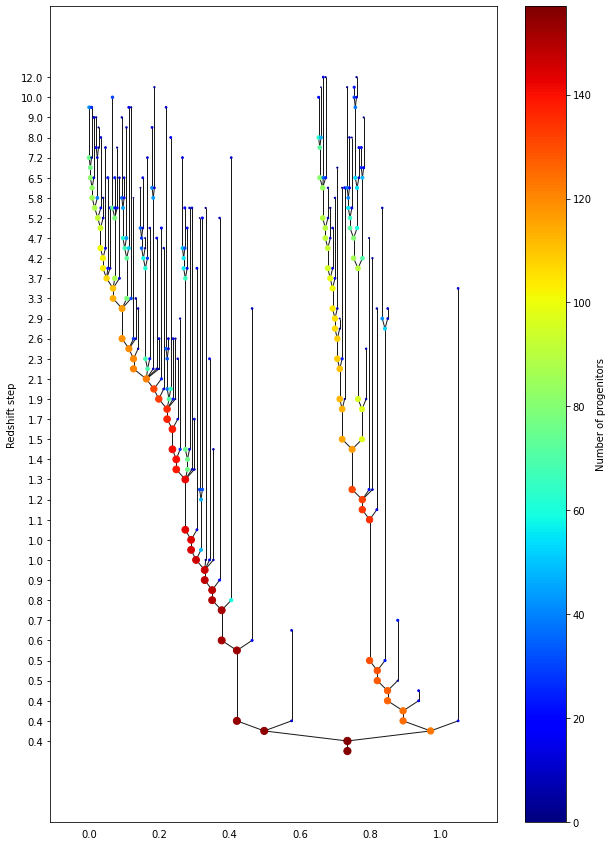

In [27]:
from matplotlib import cm
cmap=cm.get_cmap(name='magma')
fig,ax=plt.subplots(figsize=(10,15))
nx.set_node_attributes(G, di, 'n_prog')
labels=nx.get_node_attributes(G, 'n_prog')
progs = set(nx.get_node_attributes(G,'n_prog').values())
mapping = dict(zip(sorted(progs),count()))
nodes = G.nodes()
colors = [mapping[G.nodes[n]['n_prog']] for n in nodes]
print('Made graph')
# G.remove_nodes_from(list(nx.isolates(G)))
pos=nx.planar_layout(G)
# pos=nx.kamada_kawai_layout(G) #this one is kinda snakey but works pretty well! Slow as hell though
# pos=nx._layout(G)
ax.set(ylabel='Redshift step')
ax.set(yticks=-np.arange(len(zs))[::2])
ax.set_yticklabels(np.round(zs,1)[::-2])

ec = nx.draw_networkx_edges(G, hpos, alpha=0.9, arrows=False, ax=ax)
nc = nx.draw_networkx_nodes(G, hpos, nodelist=nodes, node_color=colors,  \
                            node_size=((feats[:,3]-min(feats[:,3])+1))**3/2, cmap=plt.cm.jet, ax=ax)
cbar = fig.colorbar(nc)
cbar.set_label('Number of progenitors')
ax.tick_params(left=True, bottom=False, labelleft=True, labelbottom=True)
# if G.number_of_nodes()<2000:
#     print('drawing')
#     nx.draw(G, labels=labels, pos=pos,ax=ax, node_size=8, arrowsize=5, cmap=cmap)

In [112]:
a=np.unique(feats[:,0])
ly=len(a)
ys=2*np.arange(ly)/(ly)-1

In [146]:
np.where(feats[3,0]==vals)[0][0]

48

In [144]:
vals, feats[3,0]

(array([0.07704, 0.0835 , 0.09094, 0.09626, 0.09998, 0.10583, 0.11096,
        0.11635, 0.12141, 0.12491, 0.13348, 0.14264, 0.15315, 0.16058,
        0.16678, 0.17654, 0.18423, 0.19317, 0.19968, 0.21237, 0.22267,
        0.23348, 0.24949, 0.29034, 0.30156, 0.31173, 0.32224, 0.41423,
        0.43433, 0.44475, 0.45326, 0.51268, 0.54011, 0.55045, 0.55833,
        0.56901, 0.57715, 0.5882 , 0.59662, 0.61674, 0.65592, 0.66531,
        0.70424, 0.71432, 0.78533, 0.87575, 0.92261, 0.93139, 0.97659,
        0.99057, 1.     ], dtype=float32),
 0.97659,
 51)

In [114]:
posy=2*(feats[:,0]/max(feats[:,0])-0.5)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62,
        64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96,
        98]),)